Python environment

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scvi
import hotspot

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
import matplotlib as mpl
# https://github.com/theislab/scanpy/issues/1720
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Read pre-processed data

In [ ]:
tmp = sc.read('data/core_GBmap.h5ad')

# filter the lymphoid population
cells = pd.read_csv('data/filtered_lymphoid.csv')
tmp.obs['cells'] = tmp.obs.index.values
adata = tmp[tmp.obs['cells'].isin(cells['cells'].values.tolist())].copy()
print(adata)

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    batch_key="author",
    layer="counts",
    subset=True)

### Create SCVI model and train it on reference dataset

In [ ]:
sca.dataset.setup_anndata(adata, layer = 'counts', batch_key="author")

In [ ]:
vae = sca.models.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    use_cuda = True # indicate to use gpu!
)

In [ ]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
vae.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  60%|██████    | 301/500 [1:09:54<45:52, 13.83s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  60%|██████    | 301/500 [1:10:08<46:22, 13.98s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  2378 s. / 500 epochs                                                


In [ ]:
reference_latent = sc.AnnData(vae.get_latent_representation())

In [ ]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent, resolution = 1)
sc.tl.umap(reference_latent)

In [ ]:
reference_latent.obsm['X_scVI'] = vae.get_latent_representation()

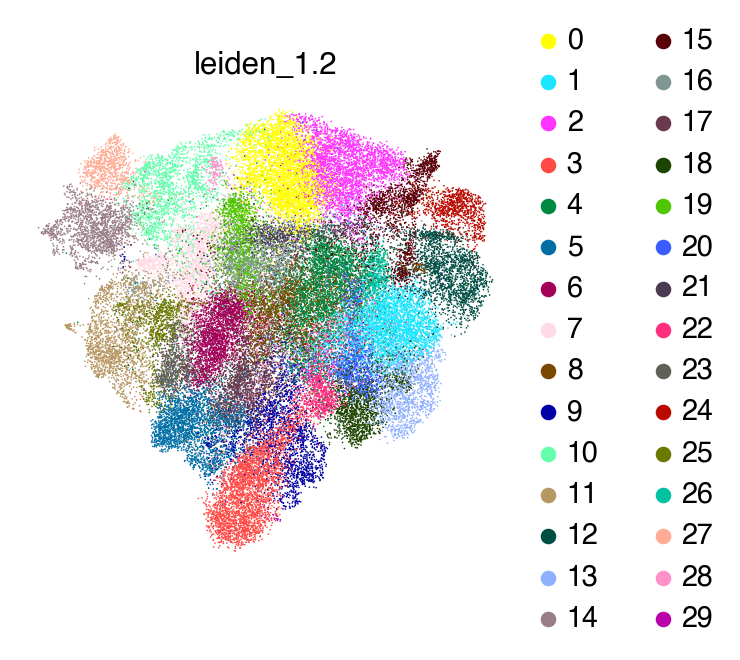

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.2, key_added= 'leiden_1.2')
sc.pl.umap(reference_latent,
           color=['leiden_1.2'],
           frameon=False,
           wspace=0.6,
           )

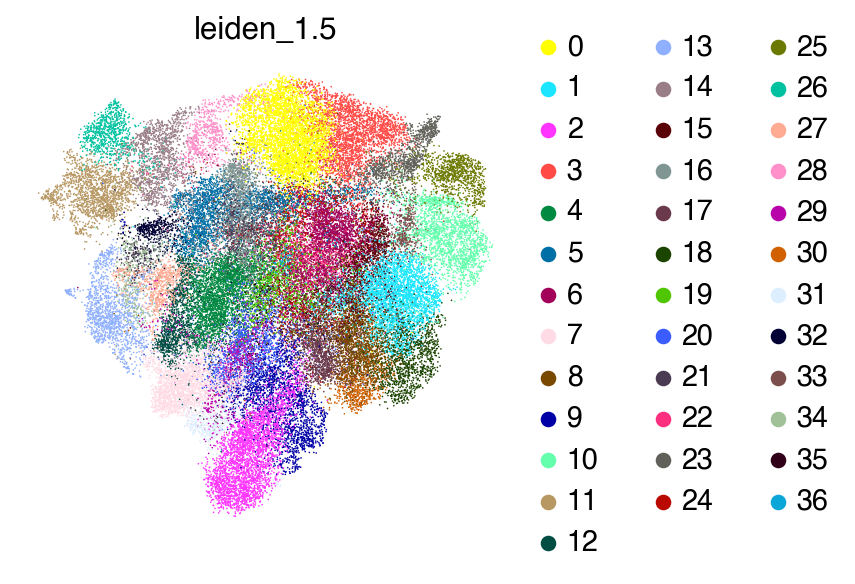

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.5, key_added= 'leiden_1.5')
sc.pl.umap(reference_latent,
           color=['leiden_1.5'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
reference_latent.write_h5ad('data/lymphoid_SCVI_1000hvg.5had')

In [ ]:
latent = vae.get_latent_representation()
counts = pd.DataFrame(adata.layers['counts'].astype('float64').todense().transpose(), columns=adata.obs.index.values, 
                      index=adata.var_names)
scvi_data = pd.DataFrame(latent,index=adata.obs.index.values)

### Creating the Hotspot object

In [ ]:
# Create the Hotspot object and the neighborhood graph
hs = hotspot.Hotspot(counts, model='danb', latent=scvi_data)

In [ ]:
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

### Determining informative genes

In [ ]:
hs_results = hs.compute_autocorrelations(jobs=18)

hs_results.head(15)

100%|██████████| 1000/1000 [00:15<00:00, 64.98it/s]


,C,Z,Pval,FDR
Gene,,,,
CCL4L2,0.480592,5198.045225,0.0,0.0
HBA2,0.272461,3093.974059,0.0,0.0
TRDC,0.474620,2493.504199,0.0,0.0
PLCG2,0.343826,2470.836504,0.0,0.0
HSP90AA1,0.688485,2174.607448,0.0,0.0
KRT81,0.501014,2131.507932,0.0,0.0
HSPH1,0.586086,2047.554852,0.0,0.0
TNFRSF4,0.437297,1772.627469,0.0,0.0
HBA1,0.250489,1758.638123,0.0,0.0


### Grouping genes into lineage-based modules

In [ ]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=18)

Computing pair-wise local correlation on 500 features...


 29%|██▉       | 36669/124750 [06:44<16:37, 88.30it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

 4     71
 9     51
 2     46
 1     46
 7     42
 3     38
 6     30
 5     30
 8     28
 13    24
-1     24
 12    19
 11    19
 14    17
 10    15
Name: Module, dtype: int64

### Plotting module correlations

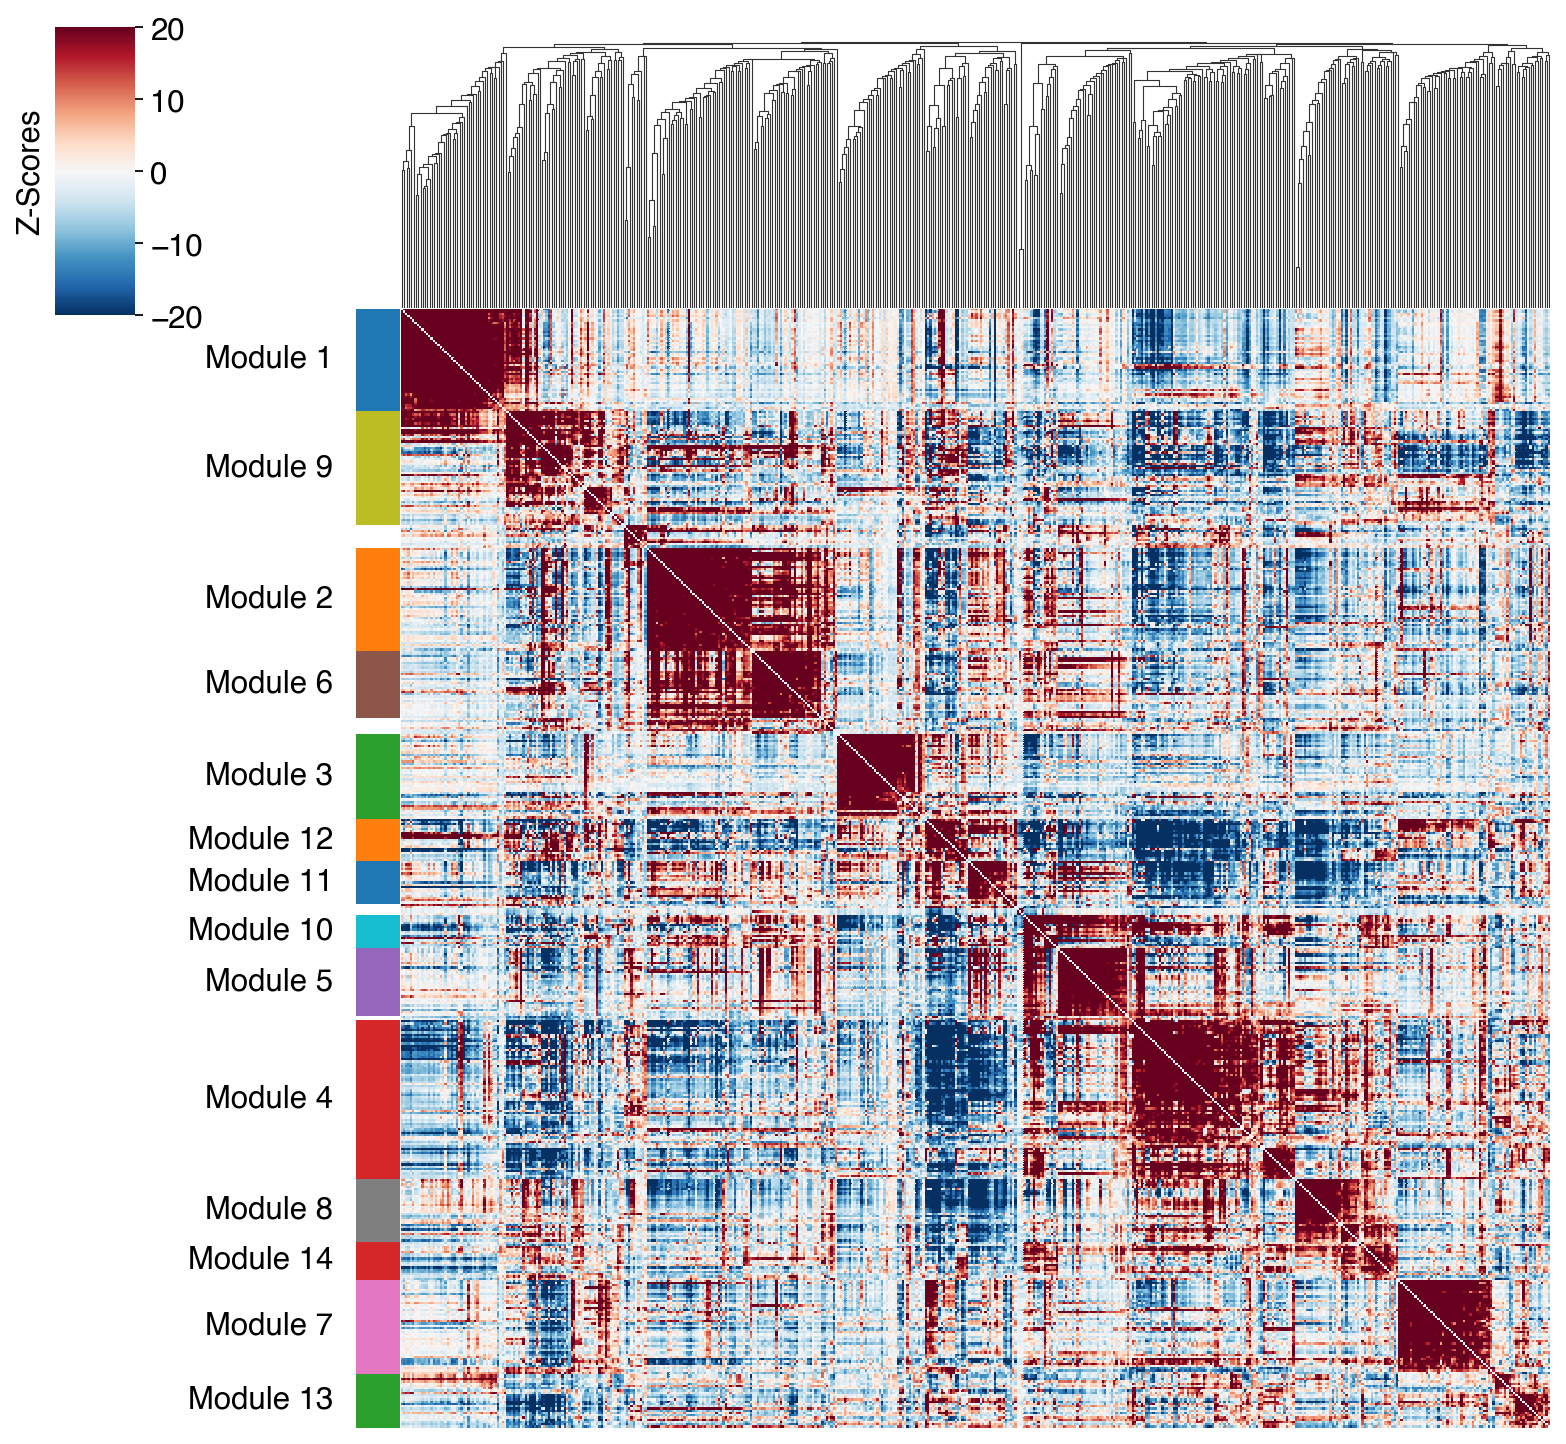

In [ ]:
hs.plot_local_correlations(vmin=-20, vmax=20)
plt.savefig('figures/lymphoid_plot_local_correlations.pdf')
# In the manuscript, the number of the modules where arranged in order from top to bottom

In [ ]:
# Show the top genes for a module

module = 1

results = hs.results.join(hs.modules)
results.to_csv('data/lymphoid_modules_hotspot_1000hvg.csv')

results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
MKI67,0.570305,1235.641604,0.0,0.0,1.0
RRM2,0.468534,1198.418695,0.0,0.0,1.0
BIRC5,0.533513,796.385044,0.0,0.0,1.0
CCNB1,0.424928,758.580227,0.0,0.0,1.0
ASPM,0.532309,747.537737,0.0,0.0,1.0
TOP2A,0.583820,705.242283,0.0,0.0,1.0
H4C3,0.420021,683.744118,0.0,0.0,1.0
CCNB2,0.483423,666.490932,0.0,0.0,1.0
TK1,0.431504,649.878438,0.0,0.0,1.0


### Summary Module Scores

In [ ]:
module_scores = hs.calculate_module_scores()

module_scores.head()

  0%|          | 0/14 [00:00<?, ?it/s]

Computing scores for 14 modules...


100%|██████████| 14/14 [00:18<00:00,  1.33s/it]


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PJ017_301,-0.198897,-1.089408,-0.929964,2.746958,0.648426,-0.391014,0.231505,0.874708,-1.968653,3.491101,-0.574550,-1.414609,0.880774,0.268396
PJ017_444,0.198417,11.137946,-1.074044,-2.674527,0.141797,4.305216,-0.041603,-1.208189,0.465860,-0.264161,-0.460652,-0.245128,-0.227121,-0.355284
PJ017_450,-0.623642,-1.140021,-0.320944,0.510366,0.467129,-0.650540,-0.521788,9.392908,-2.529151,-0.793487,-0.701384,-1.808647,0.322011,-0.170468
PJ017_489,-0.330467,2.631128,-0.860019,2.126783,-0.734034,10.941496,-0.759410,-0.862890,-0.238221,3.500657,-1.105430,-2.086801,-0.253916,-0.049238
PJ017_491,-0.698824,-0.363567,-0.331815,1.725090,-0.766752,-0.262696,-0.727994,-0.555202,0.272148,0.868420,-0.721958,0.304212,0.142485,-0.278494


In [ ]:
module_scores.to_csv('data/lymphoid_modules_scores_hotspot.csv')